In [157]:
import yfinance as yf
import pandas as pd
import numpy as np

df = yf.download("EURGBP=X", start="2021-07-09", end="2023-07-09", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [42]:
# Relative strength index manually

def rsi(df, periods = 14):
    close_delta = df['Close'].diff()
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

# rsi_values = rsi(df, 14)

In [43]:
# Commodity channel index

def calculate_cci(dataframe, period=20):
    typical_price = (dataframe['High'] + dataframe['Low'] + dataframe['Close']) / 3
    mean_deviation = typical_price.rolling(window=period).apply(lambda x: np.fabs(x - x.mean()).mean(), raw=True)
    cci = (typical_price - typical_price.rolling(window=period).mean()) / (0.015 * mean_deviation)
    return cci

#cci_values=calculate_cci(df, 20)

In [44]:
# Average true range

def calculate_atr(dataframe, period=14):
    high = dataframe['High']
    low = dataframe['Low']
    close = dataframe['Close']
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.ewm(span=period, adjust=False).mean()
    return atr

#atr_values=calculate_atr(df, 14)

In [158]:
# Using pandas technical indicators lib

import pandas_ta as ta

# Relative strength index
df["RSI"] = ta.rsi(df.Close, length=16)

# Commodity channel index
df["CCI"] = ta.cci(df.High, df.Low, df.Close, length=16)

# Average true range
df["ATR"] = ta.atr(df.High, df.Low, df.Close, length=16)

# Awesome Oscillator
df["AO"] = ta.ao(df.High, df.Low, length=16)

# Momentum Indicator
df["MOM"] = ta.mom(df.Close, length=16)

# Moving average convergence divergence 
macd = ta.macd(df.Close, length=16)
df = df.join(macd)

# Balance of Power
df["BOP"] = ta.bop(df.Open, df.High, df.Low, df.Close, Length=16)


In [136]:
df.dropna(inplace=True)

In [159]:
pipdiff = 200*1e-4

SLTPRatio = 2

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['High'])
    low = list(df1['Low'])
    close = list(df1['Close'])
    open = list(df1['Open'])
    trendcat = [None]*length
    for line in range (0, length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
            if ((valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio))):
                trendcat[line] = 1
                break
            elif ((valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff)):
                trendcat[line] = 2
                break
            else:
                trendcat[line] = 0
    return trendcat

In [ ]:
def signal_generator(df):
    open = df.Open.iloc[-1]
    close = df.Close.iloc[-1]
    prev_open = df.Open.iloc[-2]
    prev_close = df.Close.iloc[-2]

    # Bearish
    if (open > close and
        prev_open < prev_close and
        close<prev_open and
        open>=prev_close):
        return 1
    
    # Bullish
    elif (open < close and
        prev_open > prev_close and
        close>prev_open and
        open<=prev_close):
        return 2
    
    # No clear pattern
    else:
        return 0

<Axes: >

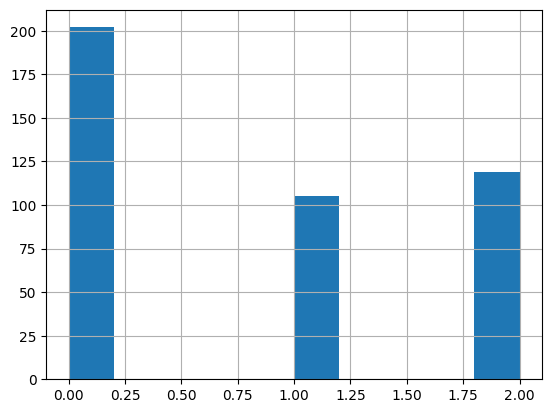

In [160]:
df['Target'] = mytarget(60, df)
df.dropna(inplace=True)

df["Target"].hist()

In [161]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split


attributes = ["RSI", "CCI", "ATR", "AO", "MOM", "MACD_12_26_9", "MACDh_12_26_9", "MACDs_12_26_9", "BOP"]

X = df[attributes]
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)

print("Accuracy on train set: {:.2f}".format(acc_train))
print("Accuracy on test set: {:.2f}".format(acc_test))

Accuracy on train set: 1.00
Accuracy on test set: 0.31
